# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# Import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import operator
import time

# Additional libraries needed
import ast
from sklearn import preprocessing as p
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from scipy import stats
from collections import Counter

# Magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=";")

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=";")

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.shape


(891221, 85)

In [4]:
# View numerical column values - azdias
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
# View the first few rows of data - azdias
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [6]:
# View column/row data type and value count info - azdias
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
# Column info - azdias
azdias.columns

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       'FINANZTYP', 'GEBURTSJAHR', 'GFK_URLAUBERTYP', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN',
       'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'PRAEGENDE_JUGENDJAHRE',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL', 'SEMIO_MAT',
       'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT', 'SEMIO_RAT',
       'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM', 'SEMIO_PFLICHT', 'SEMIO_TRADV',
       'SHOPPER_TYP', 'SOHO_KZ', 'TITEL_KZ', 'VERS_TYP', 'ZABEOTYP',
       'ALTER_HH', 'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE',
       'KK_KUNDENTYP', 'W_KEIT_KIND_HH', 'WOHNDAUER_2008',
       'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'GEBAEUDETYP', 'KONSUMNAEHE',
       'MIN_

In [8]:
# Structure of data - feat_info
feat_info.shape

(85, 4)

In [9]:
# View numerical column values - feat_info
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,CAMEO_DEU_2015,person,ordinal,[-1]
freq,1,43,49,26


In [10]:
# View the first few rows of data - feat_info
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [11]:
# View column/row data type and value count info - feat_info
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


In [12]:
# Columns info - feat_info
feat_info.columns

Index(['attribute', 'information_level', 'type', 'missing_or_unknown'], dtype='object')

In [13]:
cols = feat_info['attribute'].values

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [14]:
# Identify missing or unknown data values and convert them to NaNs.
print('Original missing data values before conversion: {}'.format(azdias.isnull().sum().sum()))


Original missing data values before conversion: 4896838


In [15]:
values = ['-1','0','1','9']
values_dict={}
for j, col in enumerate(cols):
#    print(feat_info[feat_info.attribute==col]['missing_or_unknown'])
    
    miss_values = feat_info[feat_info.attribute == col]['missing_or_unknown'].values
    for i in range(len(miss_values)):
        miss_values[i] = miss_values[i].strip('[').strip(']').split(',')
    #azdias = azdias.replace({feat_info.iloc[j][0]: missing_values}, np.nan,inplace=True)
    for i in range(len(miss_values[0])):
        if miss_values[0][i] in values:
                miss_values[0][i] = int(miss_values[0][i])
    #if missing_value[0] != ['']:
        #print(feat_info.iloc[j][0])
    #values_dict[feat_info.iloc[j][0]] =  missing_value[0]
    azdias[col] = azdias[col].replace(miss_values[0], np.nan)
    #if azdias.loc[col][j] is in missing_value[0][j]:
        

In [16]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [17]:
final_missing_data = azdias.isnull().sum().sum()
print("Final Missing Data After mapping : {}".format(final_missing_data))

Final Missing Data After mapping : 8373929


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [18]:
# Perform an assessment of how much missing data there is in each column of the dataset.
missing_values = (azdias.isnull().sum() / azdias.shape[0]).sort_values(ascending = False) * 100
missing_values

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

(array([ 32.,   0.,  26.,  18.,   3.,   0.,   0.,   0.,   1.,   0.,   0.,
          1.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   1.]),
 array([  0.        ,   3.99030543,   7.98061087,  11.9709163 ,
         15.96122174,  19.95152717,  23.94183261,  27.93213804,
         31.92244348,  35.91274891,  39.90305435,  43.89335978,
         47.88366522,  51.87397065,  55.86427609,  59.85458152,
         63.84488696,  67.83519239,  71.82549783,  75.81580326,
         79.8061087 ,  83.79641413,  87.78671957,  91.777025  ,
         95.76733044,  99.75763587]),
 <a list of 25 Patch objects>)

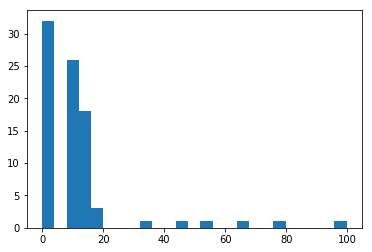

In [19]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(missing_values,bins=25)

In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
outlier_cols = []
for col in range(azdias.shape[1]):
    present_col = missing_values.index[col]
    null_percent_column = missing_values[col]
    if null_percent_column > 20:
        outlier_cols.append(present_col)

In [21]:
# Outlier columns
outlier_cols

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [22]:
# Drop Outlier columns
azdias = azdias.drop(outlier_cols, axis = 1)

In [23]:
# After dropping columns
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column
You can see from the histogram above, that there are 6 columns to the right of the 20% missing significant values, which are the outliers. The columns are outliers and can impact the model, so it's best to drop them.

#### Columns Removed:

- 'TITEL_KZ'
- 'AGER_TYP'
- 'KK_KUNDENTYP'
- 'KBA05_BAUMAX'
- 'GEBURTSJAHR'
- 'ALTER_HH' 


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [24]:
# How much data is missing in each row of the dataset? - Step 1
miss_row_data = azdias.isnull()
tot_miss_row = miss_row_data.sum(axis = 1)

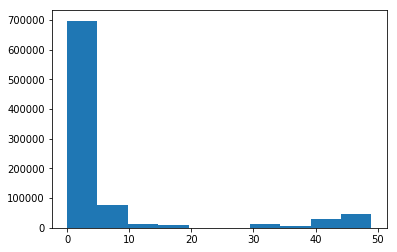

In [25]:
tot_miss_row.hist(grid = False)

In [26]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Using 30 as threshold
data_miss_high_30 = azdias[azdias.isnull().sum(axis=1) >= 30]
data_miss_low_30 = azdias[azdias.isnull().sum(axis=1) < 30]

print('Rows with data missing higher than 30 :', data_miss_high_30.shape[0], 'or', \
      np.round(data_miss_high_30.shape[0]*100/azdias.shape[0],2), '% of all data')

Rows with data missing higher than 30 : 93160 or 10.45 % of all data


In [27]:
# Columns with zero missing data values
zero_miss_cols = []

for i in range(missing_values.shape[0]):
    if(missing_values[i] == 0):
        zero_miss_cols.append(missing_values.index[i])
        
zero_miss_cols

['FINANZTYP',
 'GREEN_AVANTGARDE',
 'FINANZ_HAUSBAUER',
 'FINANZ_UNAUFFAELLIGER',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'FINANZ_MINIMALIST',
 'ANREDE_KZ',
 'FINANZ_VORSORGER',
 'SEMIO_FAM',
 'SEMIO_SOZ',
 'SEMIO_REL',
 'SEMIO_MAT',
 'SEMIO_VERT',
 'SEMIO_LUST',
 'SEMIO_ERL',
 'SEMIO_KULT',
 'SEMIO_RAT',
 'SEMIO_KRIT',
 'SEMIO_DOM',
 'SEMIO_KAEM',
 'SEMIO_PFLICHT',
 'SEMIO_TRADV',
 'ZABEOTYP']

In [28]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
 
def compare_chart(column_name):
    fig = plt.figure(10, figsize=(12,4))
    
    ax1 = fig.add_subplot(121)
    ax1.title.set_text('More Missing Rows')
    sns.countplot(data_miss_high_30[column_name])
    
    ax2 = fig.add_subplot(122)
    ax2.title.set_text('Less Missing Rows')
    sns.countplot(data_miss_low_30[column_name])
                                                       
    fig.suptitle(col)
    plt.show()

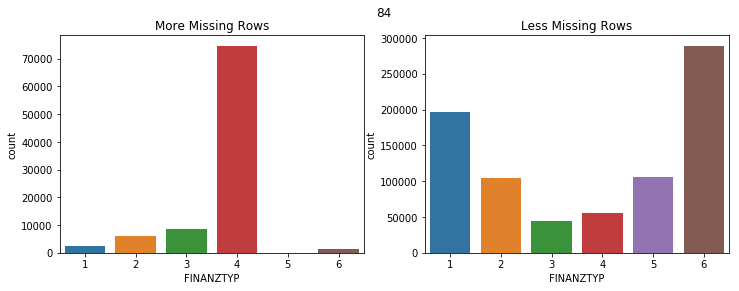

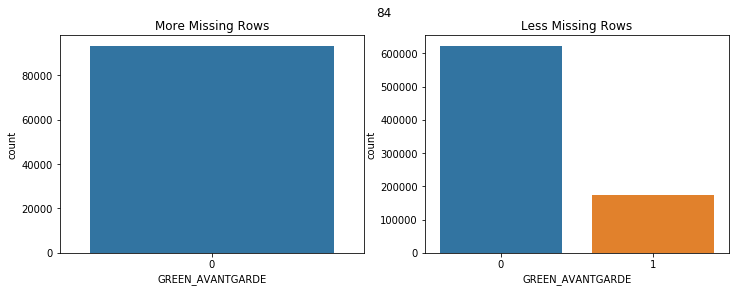

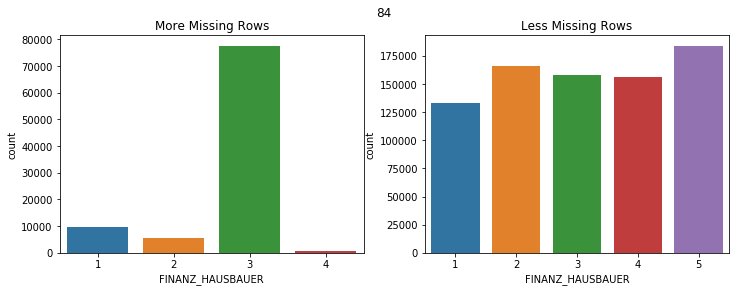

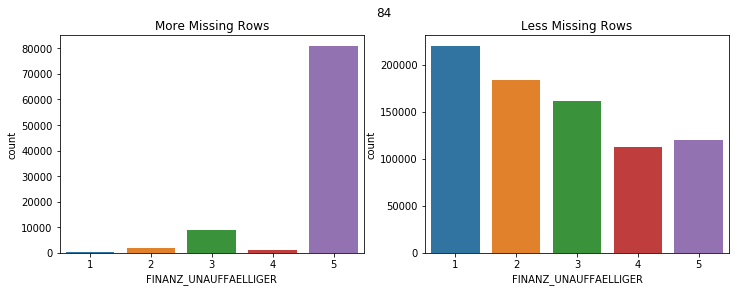

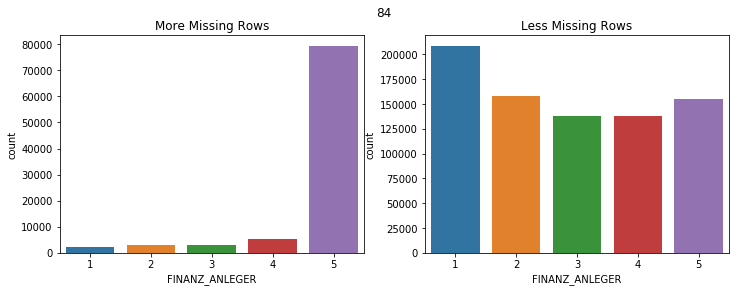

In [29]:
# Display and compare Histogram Charts

for i in range(5):
    compare_chart(zero_miss_cols[i])

In [30]:
data_miss_low_30 = data_miss_low_30.fillna(data_miss_low_30.mode().iloc[0])

In [31]:
data_miss_low_30.shape

(798061, 79)

### Discussion 1.1.3: Assess Missing Data in Each Row

We divided the data into two segments and compared the data for specific column values. You can see nearly 10% of row data has missing more than 30 values that isn't needed. So this can to ease any further processing. We'll use the dataset that's below 30% of missing data.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [32]:
# How many features are there of each data type?
feat_info = feat_info[feat_info.attribute.isin(list(azdias.columns.values))]

In [33]:
feat_info.type.value_counts()

ordinal        49
categorical    18
numeric         6
mixed           6
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [34]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
cat_var = feat_info[feat_info.type == 'categorical']
cat_var

,attribute,information_level,type,missing_or_unknown
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
10,FINANZTYP,person,categorical,[-1]
12,GFK_URLAUBERTYP,person,categorical,[]
13,GREEN_AVANTGARDE,person,categorical,[]
17,LP_FAMILIE_FEIN,person,categorical,[0]
18,LP_FAMILIE_GROB,person,categorical,[0]
19,LP_STATUS_FEIN,person,categorical,[0]
20,LP_STATUS_GROB,person,categorical,[0]
21,NATIONALITAET_KZ,person,categorical,"[-1,0]"


In [35]:
# Separate Binary and Multi-Level Binary variables
col_bin = []
col_multi = []

for column in cat_var.attribute.values:
    if data_miss_low_30[column].nunique() > 2:
        col_multi.append(column)
    else:
        col_bin.append(column)


In [36]:
# Multi-level Columns
col_multi

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [37]:
# Binary columns
col_bin

['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']

In [38]:
data_miss_low_30['OST_WEST_KZ'].unique()

array(['W', 'O'], dtype=object)

In [39]:
#Check for binary which need to be encoded
for col in col_bin:
    if data_miss_low_30[col].dtypes == object:
        print(data_miss_low_30[col].value_counts())

W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [40]:
data_miss_low_30.shape

(798061, 79)

In [41]:
# Dropping the multilevel categorical columns
data_miss_low_30.drop(col_multi, axis = 1, inplace = True)

In [42]:
data_miss_low_30.shape

(798061, 66)

In [43]:
# Checking column values to be encoded
for col in col_bin:
    print(data_miss_low_30[col].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
W    629520
O    168541
Name: OST_WEST_KZ, dtype: int64


In [44]:
# Converting categorical binary variables with non-numeric values to numeric
data_miss_low_30.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True)

In [45]:
# Checking values after conversion
for col in col_bin:
    print(data_miss_low_30[col].value_counts())

2    416177
1    381884
Name: ANREDE_KZ, dtype: int64
0    622836
1    175225
Name: GREEN_AVANTGARDE, dtype: int64
0.0    791344
1.0      6717
Name: SOHO_KZ, dtype: int64
2.0    430959
1.0    367102
Name: VERS_TYP, dtype: int64
0    629520
1    168541
Name: OST_WEST_KZ, dtype: int64


In [46]:
data_miss_low_30.shape

(798061, 66)

### Discussion 1.2.1: Re-Encode Categorical Features

All multi-level categorical features were removed. The encoding and conversion of the non-numeric binary colum 'OST_WEST_KZ'was completed. From [W, O] to [0, 1]. All other binary features still available: 'ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP'.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [47]:
# Investigate "PRAEGENDE_JUGENDJAHRE" 
mix_var = feat_info[feat_info.type == 'mixed']
mix_var

,attribute,information_level,type,missing_or_unknown
15,LP_LEBENSPHASE_FEIN,person,mixed,[0]
16,LP_LEBENSPHASE_GROB,person,mixed,[0]
22,PRAEGENDE_JUGENDJAHRE,person,mixed,"[-1,0]"
56,WOHNLAGE,building,mixed,[-1]
59,CAMEO_INTL_2015,microcell_rr4,mixed,"[-1,XX]"
79,PLZ8_BAUMAX,macrocell_plz8,mixed,"[-1,0]"


#### PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)

- -1: unknown
- 0: unknown
- 1: 40s - war years (Mainstream, E+W)
- 2: 40s - reconstruction years (Avantgarde, E+W)
- 3: 50s - economic miracle (Mainstream, E+W)
- 4: 50s - milk bar / Individualisation (Avantgarde, E+W)
- 5: 60s - economic miracle (Mainstream, E+W)
- 6: 60s - generation 68 / student protestors (Avantgarde, W)
- 7: 60s - opponents to the building of the Wall (Avantgarde, E)
- 8: 70s - family orientation (Mainstream, E+W)
- 9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [48]:
# Investigate "PRAEGENDE_JUGENDJAHRE" 
# Create two new functions

# Based on birth
def decade(x):
    if x in (1,2):
        return 1
    elif x in (3,4):
        return 2
    elif x in (5,6,7):
        return 3
    elif x in (8,9):
        return 4
    elif x in (10,11,12,13):
        return 5
    elif x in (14,15):
        return 6

# Based on movement    
def movement(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    elif x in (1,3,5,8,10,12,14):
        return 1

In [49]:
# Investigate "PRAEGENDE_JUGENDJAHRE" 
# Create new columns "DECADES"  and 'MOVEMENTS' based on decade of birth and movement 

data_miss_low_30['PRAEGENDE_JUGENDJAHRE_DECADE'] = data_miss_low_30['PRAEGENDE_JUGENDJAHRE'].apply(decade)
data_miss_low_30['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = data_miss_low_30['PRAEGENDE_JUGENDJAHRE'].apply(movement)
data_miss_low_30.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace = True)

#### CAMEO_INTL_2015 German CAMEO

Wealth / Life Stage Typology, mapped to international code

- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families & Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [50]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

# Adding a feature based on wealth
def wealth(x):
    if int(x) // 10 == 1:
        return 1
    elif int(x) // 10 == 2:
        return 2
    elif int(x) // 10 == 3:
        return 3
    elif int(x) // 10 == 4:
        return 4
    elif int(x) // 10 == 5:
        return 5
# Adding a feature based on lfe stage
def life_stage(x):
    if int(x) % 10 == 1:
        return 1
    elif int(x) % 10 == 2:
        return 2
    elif int(x) % 10 == 3:
        return 3
    elif int(x) % 10 == 4:
        return 4
    elif int(x) % 10 == 5:
        return 5

In [51]:
# Check null
data_miss_low_30.isnull().sum().sum()

0

In [52]:
# Investigate "CAMEO_INTL_2015" - Step 5
# Create new columns 'WEALTH' and 'LIFE_STAGE' based on wealth and stage of life
data_miss_low_30['CAMEO_INTL_2015_WEALTH'] = data_miss_low_30['CAMEO_INTL_2015'].apply(wealth)
data_miss_low_30['CAMEO_INTL_2015_LIFE_STAGE'] = data_miss_low_30['CAMEO_INTL_2015'].apply(life_stage)
data_miss_low_30.drop('CAMEO_INTL_2015', axis=1, inplace = True)

### Discussion 1.2.2: Engineer Mixed-Type Features

The following two features stayed:

- PRAEGENDE_JUGENDJAHRE
- CAMEO_INTL_2015

Steps to engineer the above two mixed-value features:

1. Created two new feature columns, and copied values from the initial mixed-values.
2  Used Data_Dictionary.md for the information and logic for data separation.
3. Dropped initial features from data.

### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:

- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from the subset with few or no missing values.

In [53]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)\
data_miss_low_30.columns.values

array(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB',
       'RETOURTYP_BK_S', 'SEMIO_SOZ', 'SEMIO_FAM', 'SEMIO_REL',
       'SEMIO_MAT', 'SEMIO_VERT', 'SEMIO_LUST', 'SEMIO_ERL', 'SEMIO_KULT',
       'SEMIO_RAT', 'SEMIO_KRIT', 'SEMIO_DOM', 'SEMIO_KAEM',
       'SEMIO_PFLICHT', 'SEMIO_TRADV', 'SOHO_KZ', 'VERS_TYP',
       'ANZ_PERSONEN', 'ANZ_TITEL', 'HH_EINKOMMEN_SCORE', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL',
       'KONSUMNAEHE', 'MIN_GEBAEUDEJAHR', 'OST_WEST_KZ', 'WOHNLAGE',
       'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3', 'KBA05_ANTG4',
       'KBA05_GBZ', 'BALLRAUM', 'EWDICHTE', 'INNENSTADT',
       'GEBAEUDETYP_RASTER', 'KKK', 'MOBI_REGIO', 'ONLINE_AFFINITAET',
       'REGIOTYP', 'KBA13_ANZAHL_PKW', 'PLZ8_ANTG1', 'PLZ8_ANTG2',


In [54]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions
data_miss_low_30.shape

(798061, 68)

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [55]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',delimiter=';')
    
    values = ['-1','0','1','9']
    values_dict = {}
    
    for j,col in enumerate(cols):
    
        missing_value = feat_info[feat_info.attribute == col]['missing_or_unknown'].values
        for i in range(len(missing_value)):
            missing_value[i] = missing_value[i].strip('[').strip(']').split(',')
        for i in range(len(missing_value[0])):
            if missing_value[0][i] in values:
                missing_value[0][i] = int(missing_value[0][i])
        df[col] = df[col].replace(missing_value[0], np.nan) 
    
    # remove selected columns and rows, ...
    missing_values =(df.isnull().sum() / df.shape[0]).sort_values(ascending = False) * 100
    
    df = df.drop(outlier_cols,axis = 1)
    
    miss_row_data = df.isnull()
    tot_miss_row = miss_row_data.sum(axis = 1)
    
    cdata_miss_high_30 = df[df.isnull().sum(axis = 1) >= 30]
    cdata_miss_low_30 = df[df.isnull().sum(axis = 1) < 30]
   
    print('Rows with data missing higher than 30 :', data_miss_high_30.shape[0], 'or', \
    np.round(data_miss_high_30.shape[0]*100/df.shape[0],2), '% of all data') 
    
    cdata_miss_low_30 = cdata_miss_low_30.fillna(cdata_miss_low_30.mode().iloc[0]) 
       
    # select, re-encode, and engineer column values.
    cat_var = feat_info[feat_info.type == 'categorical']
    
    # Convert binary categorical feature to numerical
    cdata_miss_low_30.replace({'OST_WEST_KZ':{'W':0, 'O': 1}}, inplace = True)
    
    # Drop the multi categorical features
    cdata_miss_low_30.drop(col_multi, axis = 1, inplace = True)
       
    cdata_miss_low_30['PRAEGENDE_JUGENDJAHRE_DECADE'] = cdata_miss_low_30['PRAEGENDE_JUGENDJAHRE'].apply(decade)
    cdata_miss_low_30['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = cdata_miss_low_30['PRAEGENDE_JUGENDJAHRE'].apply(movement)
    cdata_miss_low_30.drop('PRAEGENDE_JUGENDJAHRE', axis = 1, inplace = True)
    
    cdata_miss_low_30['CAMEO_INTL_2015_WEALTH'] = cdata_miss_low_30['CAMEO_INTL_2015'].apply(wealth)
    cdata_miss_low_30['CAMEO_INTL_2015_LIFE_STAGE'] = cdata_miss_low_30['CAMEO_INTL_2015'].apply(life_stage)
    cdata_miss_low_30.drop('CAMEO_INTL_2015', axis = 1, inplace = True) 
    
    # Return the cleaned dataframe.
    return cdata_miss_low_30
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [56]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
data_miss_low_30.isnull().sum().sum()

0

In [57]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
data_miss_low_30[list(data_miss_low_30.columns)] = scaler.fit_transform(data_miss_low_30[list(data_miss_low_30.columns)])

In [58]:
data_miss_low_30.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,PRAEGENDE_JUGENDJAHRE_DECADE,PRAEGENDE_JUGENDJAHRE_MOVEMENT,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE
1,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,-0.633274,1.455847,0.574305,-0.171400,-0.127041,0.684882,1.098070,0.530409,1.175657,-1.248894
2,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.633274,0.419740,0.574305,-0.171400,-0.127041,-0.789027,1.098070,-1.885336,-0.869680,0.767095
3,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.633274,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,-0.267778,0.530409,-1.551459,-0.576897
4,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,0.057855,-0.616366,-0.337195,0.830348,0.308213,1.421837,-0.267778,0.530409,0.493878,0.095099
5,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,-0.633274,1.455847,1.485805,-1.173149,-0.997549,-0.052072,-1.633627,0.530409,1.175657,0.767095


### Discussion 2.1: Apply Feature Scaling

All NaN values have been filled utilizing the Imputer instance. There were a lot of NaN's in the dataset as it relates to the number observed.

The instance has been used for scaling each feature to mean 0 and standard deviation 1, using StandardScaler.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [59]:
# Apply PCA to the data.
pca = PCA()
pca_below30 = pca.fit_transform(data_miss_low_30)

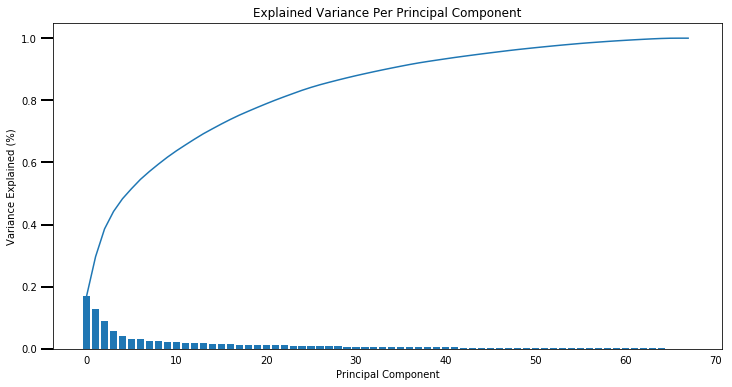

In [60]:
# Investigate the variance accounted for by each principal component.
def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    
    Credit:Udacity Nanodegree
    '''
    num_components = len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
    
 
    plt.figure(figsize=(12, 6))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)

    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    

scree_plot(pca)


In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components = 30)
pca_below30 = pca.fit_transform(data_miss_low_30)

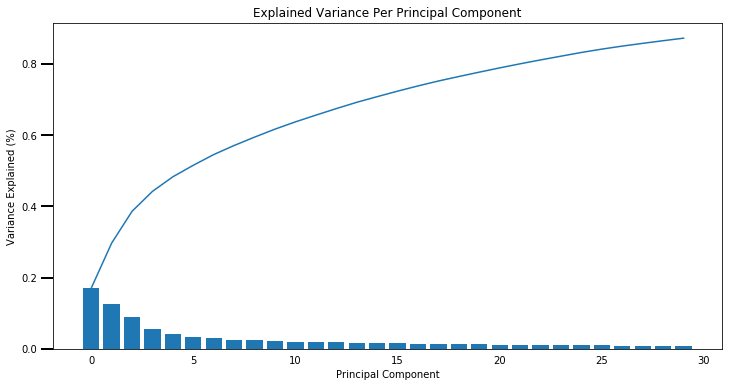

In [62]:
scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction

After the initial PCA on the dataset and a n_components of 60, I'm using 30 for the components for the second step for the analysis. There's approximately an 80% variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [63]:
# Function for calculating weights of the components

def weights(nth_pc, pca, df):
    name_list = list(df.columns)
    weights_list = list(pca.components_[nth_pc])
    df = pd.DataFrame(list(zip(name_list, weights_list)))
    df.set_axis(['Feature', 'Weights'], axis = 1, inplace = True)
    df = df.sort_values(by = ['Weights'] , ascending = False)
    df.set_index('Feature', inplace = True)
    return df

In [64]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells. Use the weights function above for displaying the feature weights.

for i in range(3):
  print('\n Top 5 positive components {}\n'.format(i))
  print(weights(i, pca, data_miss_low_30).head(5))
  print('\n Top 5 negative components {}\n'.format(i))
  print(weights(i, pca, data_miss_low_30).tail(5))
  print('-----------------------------------------------')



 Top 5 positive components 0

                         Weights
Feature                         
PLZ8_ANTG3              0.224012
PLZ8_ANTG4              0.217123
PLZ8_BAUMAX             0.213998
CAMEO_INTL_2015_WEALTH  0.199635
ORTSGR_KLS9             0.197310

 Top 5 negative components 0

                    Weights
Feature                    
FINANZ_MINIMALIST -0.204049
KBA05_ANTG1       -0.208385
KBA05_GBZ         -0.211614
MOBI_REGIO        -0.219234
PLZ8_ANTG1        -0.224253
-----------------------------------------------

 Top 5 positive components 1

                       Weights
Feature                       
ALTERSKATEGORIE_GROB  0.269887
FINANZ_VORSORGER      0.242487
SEMIO_ERL             0.235372
SEMIO_LUST            0.188482
RETOURTYP_BK_S        0.163506

 Top 5 negative components 1

                               Weights
Feature                               
SEMIO_TRADV                  -0.237954
SEMIO_PFLICHT                -0.239038
FINANZ_SPARER               

In [65]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# pca_weight_0 = weights(0, pca, data_miss_low_30)
# print (pca_weight_0)

In [66]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# pca_weight_1 = weights(1, pca, data_miss_low_30)
# print (pca_weight_1)

In [67]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

# pca_weight_2 = weights(2, pca, data_miss_low_30)
# print (pca_weight_2)

### Discussion 2.3: Interpret Principal Components

1. First Principal Component

    - Positive weights
        - LP_STATUS_GROB_1.0 (single: maps to 1 in fine scale )
        - HH_EINKOMMEN_SCORE (Estimated house net income)
    - Negative weights
        - KBA05_ANTG1 (Number of 1-2 family houses in the microcell)
        - KBA05_GBZ (Number of buildings in microcell)
        
2. Second Principal Component

    - Positive weights
        - ALTERSKATEGORIE_GROB (Estimated age based on given name analysis)
        - FINANZ_VORSORGER(Financial typology: be prepared)
    - Negative weights
        - SEMIO_TRADV (Personality typology: traditional-minded)
        - FINANZ_UNAUFFAELLIGER (Financial typology: inconspicuous)
        
3. Third Principal Component

    - Positive weights
        - SEMIO_VERT (Personality typology: dreamful)
        - SEMIO_FAM (Personality typology:family-minded)

    - Negative weights
        - SEMIO_ERL (Personality typology:event-oriented)
        - SEMIO_KRIT (Personality typology: critical-minded)

From the analysis above the first component is about location and number of family houses and buildings. The second component is about financial typologies, age and religion. An lastly the third component, is all about personality typologies.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [68]:
# Over a number of different cluster counts...
from time import time

average=[]
start = time()

for i in range(2,15,2):
    # run k-means clustering on the data and...
    kmeans = KMeans(n_clusters=i).fit(pca_below30)
    # Obtain a score related to the model fit
    score = np.abs(kmeans.score(pca_below30))
    # compute the average within-cluster distances.
    print("For n_clusters={}, average within-cluster distances = {}".format(i,score/pca_below30.shape[0]))
    average.append(score/pca_below30.shape[0])
    
end = time()
print(end - start)

For n_clusters=2, average within-cluster distances = 50.698154366861694
For n_clusters=4, average within-cluster distances = 43.942737890568395
For n_clusters=6, average within-cluster distances = 40.53285772745253
For n_clusters=8, average within-cluster distances = 38.04001178295684
For n_clusters=10, average within-cluster distances = 36.42310694681228
For n_clusters=12, average within-cluster distances = 35.03053627286291
For n_clusters=14, average within-cluster distances = 34.50017789997908
699.9473178386688


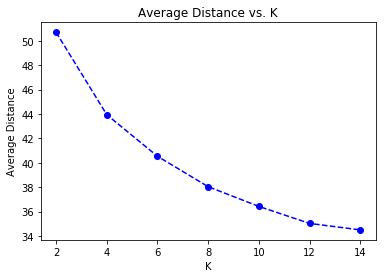

In [69]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
n = [2, 4, 6, 8, 10, 12, 14]
plt.plot(n, average, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('Average Distance');
plt.title('Average Distance vs. K');

In [100]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.

# kmeans_pred_general = KMeans(n_clusters=14).fit_predict(pca_below30)

kmeans = KMeans(n_clusters = 14)
model = kmeans.fit(pca_below30)
azdias_pred = model.predict(pca_below30)

### Discussion 3.1: Apply Clustering to General Population

I utilized the sklearn's KMeans class to perform k-means clustering on the PCA-transformed data then I fitted the k-means model with number of clusters, as 14. The change is within the cluster distance across the clusters.


### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [71]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',delimiter=';')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [72]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
customers_clean = clean_data(customers)

Rows with data missing higher than 30 : 93160 or 48.61 % of all data


In [73]:
customers_clean.shape

(141725, 68)

In [74]:
data_miss_low_30.shape

(798061, 68)

In [75]:
list(set(data_miss_low_30.columns)-set(customers_clean.columns))

[]

In [76]:
# Scaling
customers_scaled = scaler.transform(customers_clean)

In [77]:
# PCA Transformation
customers_pca = pca.transform(customers_scaled)

In [78]:
# Predict clustering on kmeans model
customers_pred = KMeans(n_clusters=14).fit_predict(customers_clean)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [79]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

In [80]:
# Predictions for General data
pred_num_general = pd.Series(kmeans_pred_general).value_counts().sort_index()
pred_num_general

0     54010
1     72817
2     53450
3     53921
4     66228
5     59964
6     70939
7     59923
8     61418
9     68654
10    54709
11     3352
12    58066
13    60610
dtype: int64

In [81]:
# Predictions for Customers Data
pred_num_customers = pd.Series(customers_pred).value_counts().sort_index()
pred_num_customers

0     10819
1     19693
2      5256
3     16570
4      6107
5      6512
6       846
7     17206
8     14035
9      2982
10     8380
11    18962
12     1395
13    12962
dtype: int64

In [82]:
# Create dataframe for each cluster and the no of person for 
# each cluster for both general and customers data
df_combo = pd.concat([pred_num_general, pred_num_customers], axis=1).reset_index()
df_combo.columns = ['clusters', 'kmeans_pred_general', 'customers_pred']
df_combo

,clusters,kmeans_pred_general,customers_pred
0,0,54010,10819
1,1,72817,19693
2,2,53450,5256
3,3,53921,16570
4,4,66228,6107
5,5,59964,6512
6,6,70939,846
7,7,59923,17206
8,8,61418,14035
9,9,68654,2982


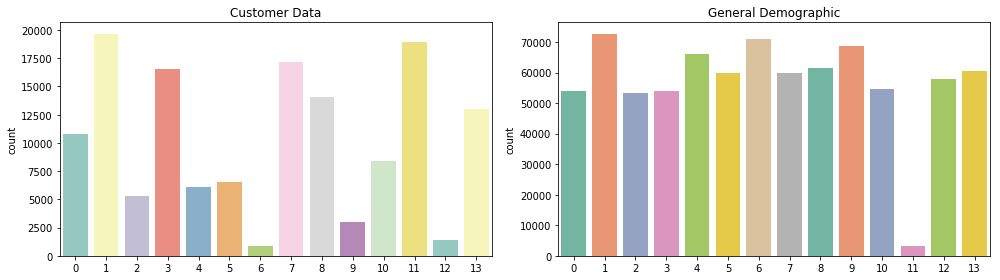

In [83]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
fig = plt.figure(figsize=(14,4))
ax1 = fig.add_subplot(121)
ax1.title.set_text('Customer Data')
sns.countplot(customers_pred, palette = 'Set3')

ax2 = fig.add_subplot(122)
ax2.title.set_text('General Demographic')
sns.countplot(kmeans_pred_general, palette = 'Set2')
fig.tight_layout() 
plt.show()

In [113]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
over_rep = model.cluster_centers_[1]
over_rep = pca.inverse_transform(over_rep)
over_rep = scaler.inverse_transform(over_rep)
over_rep = pd.Series(data = over_rep, index = data_miss_low_30.columns)

In [114]:
over_rep

ALTERSKATEGORIE_GROB                3.571319
ANREDE_KZ                           1.978814
FINANZ_MINIMALIST                   2.482881
FINANZ_SPARER                       1.897648
FINANZ_VORSORGER                    4.291715
FINANZ_ANLEGER                      2.223292
FINANZ_UNAUFFAELLIGER               1.749145
FINANZ_HAUSBAUER                    4.401362
GREEN_AVANTGARDE                    0.054747
HEALTH_TYP                          1.999383
LP_LEBENSPHASE_FEIN                11.069383
LP_LEBENSPHASE_GROB                 3.527968
RETOURTYP_BK_S                      4.274727
SEMIO_SOZ                           3.195315
SEMIO_FAM                           2.176948
SEMIO_REL                           2.047026
SEMIO_MAT                           2.408773
SEMIO_VERT                          2.720611
SEMIO_LUST                          5.303148
SEMIO_ERL                           6.583452
SEMIO_KULT                          1.857250
SEMIO_RAT                           3.361231
SEMIO_KRIT

In [115]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
under_rep = model.cluster_centers_[6]
under_rep = pca.inverse_transform(under_rep)
under_rep = scaler.inverse_transform(under_rep)
under_rep = pd.Series(data = under_rep, index = data_miss_low_30.columns)

In [116]:
under_rep

ALTERSKATEGORIE_GROB                3.297216
ANREDE_KZ                           1.064226
FINANZ_MINIMALIST                   3.477585
FINANZ_SPARER                       2.027392
FINANZ_VORSORGER                    4.173951
FINANZ_ANLEGER                      1.868667
FINANZ_UNAUFFAELLIGER               1.898744
FINANZ_HAUSBAUER                    3.272974
GREEN_AVANTGARDE                    0.046450
HEALTH_TYP                          2.426132
LP_LEBENSPHASE_FEIN                11.292889
LP_LEBENSPHASE_GROB                 3.544057
RETOURTYP_BK_S                      4.243781
SEMIO_SOZ                           4.830785
SEMIO_FAM                           5.111817
SEMIO_REL                           3.886614
SEMIO_MAT                           4.159916
SEMIO_VERT                          5.731254
SEMIO_LUST                          4.956762
SEMIO_ERL                           4.265310
SEMIO_KULT                          4.972051
SEMIO_RAT                           2.704187
SEMIO_KRIT

### Discussion 3.3: Compare Customer Data to Demographics Data

You can see from the Analysis above that the customer data is overrepresented for Cluster 1 compared to the general population as it relates to the mail order company.

#### Cluster 1 (overrepresented customers):

- ALTERSKATEGORIE_GROB 3.571319: The age is around 60
- ANREDE_KZ 1.978814: The gender is female
- PLZ8_ANTG3 2.318616: In this area 6-10 family homes is average

The customer data for Cluster 6 is underrepresented within the analysis. Some features in this segment of the population are somewhat unpopular with the company.

#### Cluster 6 (underrepresented customers):

- ALTERSKATEGORIE_GROB 3.297216: The age is around 40 - 60
- ANREDE_KZ 1.064226: The gender is male
- PLZ8_ANTG3 1.756026: In this area 6-10 family homes is lower

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.